In [1]:
pip install utils 

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install tensorflow

In [39]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception, ResNet50, VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [9]:
data_dir = r"C:\Users\ROSHAN JERUSH\Desktop\chest_xray"
train_path = os.path.join(data_dir, 'train')
test_path = os.path.join(data_dir, 'test')

In [11]:
import cv2
print(cv2.__version__)

4.10.0


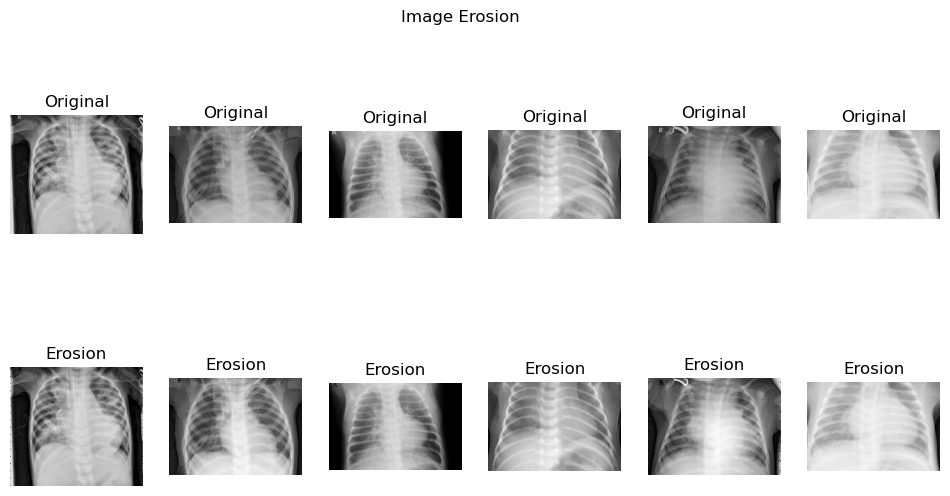

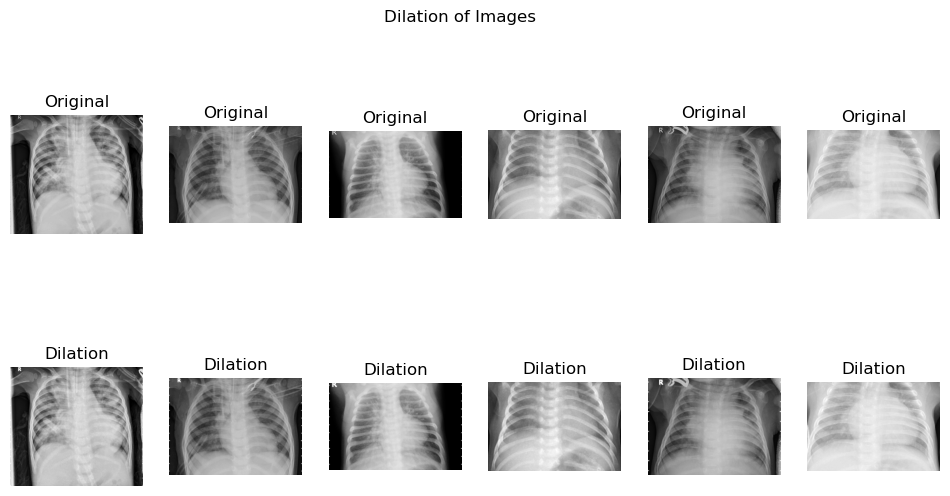

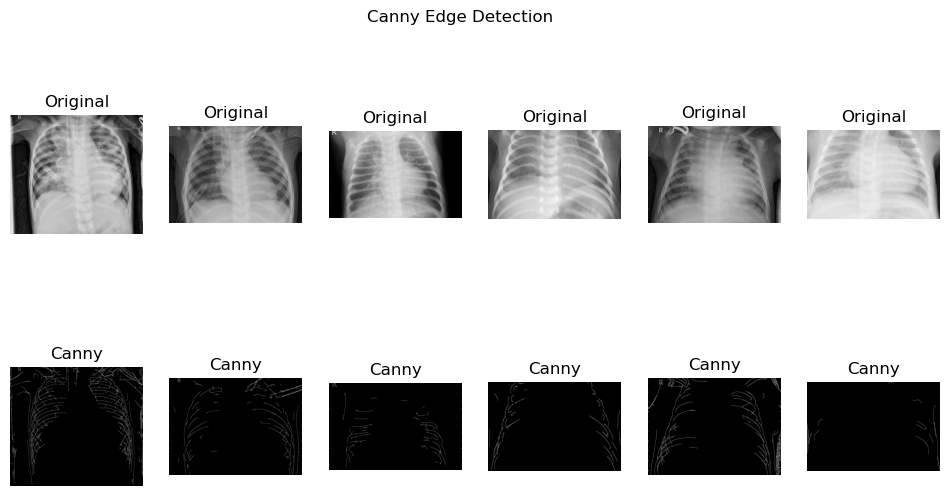

In [13]:
# Function to apply image processing techniques
def process_image(image_path, operation='erosion'):
    img = cv2.imread(image_path, 0)  # Load image in grayscale
    kernel = np.ones((5, 5), np.uint8)
    
    if operation == 'erosion':
        processed_img = cv2.erode(img, kernel, iterations=1)
    elif operation == 'dilation':
        processed_img = cv2.dilate(img, kernel, iterations=1)
    elif operation == 'canny':
        processed_img = cv2.Canny(img, 50, 150)
    else:
        raise ValueError("Unsupported operation")
    
    return processed_img

# Function to visualize image processing effects
def visualize_processing(directory, operation, title, num_images=6):
    image_files = [os.path.join(directory, img) for img in os.listdir(directory)[:num_images]]
    plt.figure(figsize=(12, 6))
    
    for i, img_path in enumerate(image_files):
        original = cv2.imread(img_path, 0)
        processed = process_image(img_path, operation)
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original, cmap='gray')
        plt.axis('off')
        plt.title("Original")
        
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(processed, cmap='gray')
        plt.axis('off')
        plt.title(operation.capitalize())
    
    plt.suptitle(title)
    plt.show()

# Visualize Erosion, Dilation, and Canny Edge Detection
pneumonia_dir = os.path.join(train_path, 'PNEUMONIA')
visualize_processing(pneumonia_dir, 'erosion', "Image Erosion")
visualize_processing(pneumonia_dir, 'dilation', "Dilation of Images")
visualize_processing(pneumonia_dir, 'canny', "Canny Edge Detection")


In [15]:
# Count classes in each dataset
def count_images(directory):
    categories = os.listdir(directory)
    count_dict = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        count_dict[category] = len(os.listdir(category_path))
    return count_dict

train_counts = count_images(train_path)
test_counts = count_images(test_path)


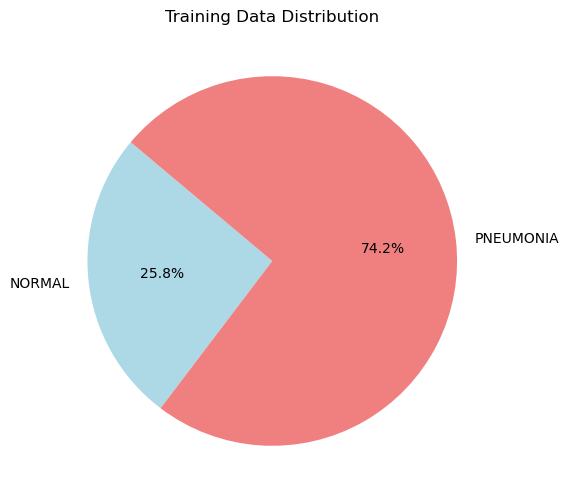

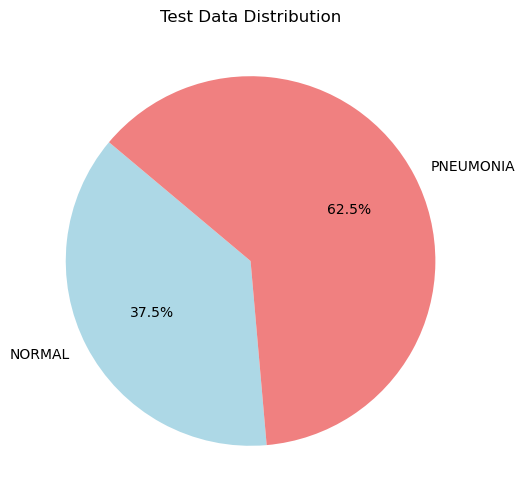

In [17]:
# Plot Pie Charts
def plot_pie_chart(data, title):
    labels = list(data.keys())
    sizes = list(data.values())
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightblue', 'lightcoral'], startangle=140)
    plt.title(title)
    plt.show()

plot_pie_chart(train_counts, 'Training Data Distribution')
plot_pie_chart(test_counts, 'Test Data Distribution')


In [19]:
import os
import random
import shutil

# Paths
train_path = r"C:\Users\ROSHAN JERUSH\Desktop\chest_xray\train"

classes = os.listdir(train_path)

# Count images in each class
train_counts = {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in classes}

# Find majority class count
max_count = max(train_counts.values())

# Oversample minority classes
for cls in classes:
    class_path = os.path.join(train_path, cls)
    images = os.listdir(class_path)
    
    # If class has fewer images, duplicate randomly until balanced
    while len(images) < max_count:
        img_to_copy = random.choice(images)
        new_img_name = f"copy_{len(images)}_{img_to_copy}"
        shutil.copy(os.path.join(class_path, img_to_copy), os.path.join(class_path, new_img_name))
        images.append(new_img_name)

    print(f"Oversampled {cls} to {max_count} images.")

print("Dataset balanced via oversampling.")

Oversampled NORMAL to 3883 images.
Oversampled PNEUMONIA to 3883 images.
Dataset balanced via oversampling.


In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
train_path = r"C:\Users\ROSHAN JERUSH\Desktop\chest_xray\train"
test_path = r"C:\Users\ROSHAN JERUSH\Desktop\chest_xray\test"

# 🔹 Data Augmentation & Normalization (For Training)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    validation_split=0.2  # 🔹 Split train data into training (80%) & validation (20%)
)

# 🔹 Load Training Data (80% of train folder)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # 🔹 Use 80% for training
)

# 🔹 Load Validation Data (20% of train folder)
valid_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # 🔹 Use 20% for validation
)

# 🔹 Test Data (No Data Augmentation, Just Normalization)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 6214 images belonging to 2 classes.
Found 1552 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [29]:
basic_cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

basic_cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\ROSHAN JERUSH\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
# Define Model Dictionary
model_dict = {
    'Basic CNN': basic_cnn_model,
}

# Updated Callbacks to Prevent Overfitting
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),  # Restores the best model
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),  # Adjusts LR when needed
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)  # Saves best model
]

# Train the Model with Improved Regularization
for name, model in model_dict.items():
    print(f"Training {name}...")
    
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=10,  # More epochs for better learning
        batch_size=32,  # Keeps batch size stable
        callbacks=callbacks,
        verbose=1
    )


Training Basic CNN...


C:\Users\ROSHAN JERUSH\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7014 - loss: 0.9617
Epoch 1: val_loss improved from inf to 0.38777, saving model to best_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 621s 3s/step - accuracy: 0.7019 - loss: 0.9596 - val_accuracy: 0.8621 - val_loss: 0.3878 - learning_rate: 0.0010
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8469 - loss: 0.4003
Epoch 2: val_loss improved from 0.38777 to 0.32482, saving model to best_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 670s 3s/step - accuracy: 0.8469 - loss: 0.4002 - val_accuracy: 0.8814 - val_loss: 0.3248 - learning_rate: 0.0010
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8547 - loss: 0.3682
Epoch 3: val_loss improved from 0.32482 to 0.29011, saving model to best_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 673s 3s/step - accuracy: 0.8548 - loss: 0.3681 - val_accuracy: 0.8930 - val_loss: 0.2901 - learning_rate: 0.0010
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.876

In [33]:
print(f"Evaluating {name}...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"{name} Test Accuracy: {test_accuracy:.2f}")

Evaluating Basic CNN...
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 662ms/step - accuracy: 0.8852 - loss: 0.3013
Basic CNN Test Accuracy: 0.88


In [35]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
print(f"{name} Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 689ms/step
Basic CNN Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.80      0.88      0.84       234
   PNEUMONIA       0.93      0.87      0.90       390

    accuracy                           0.88       624
   macro avg       0.86      0.88      0.87       624
weighted avg       0.88      0.88      0.88       624



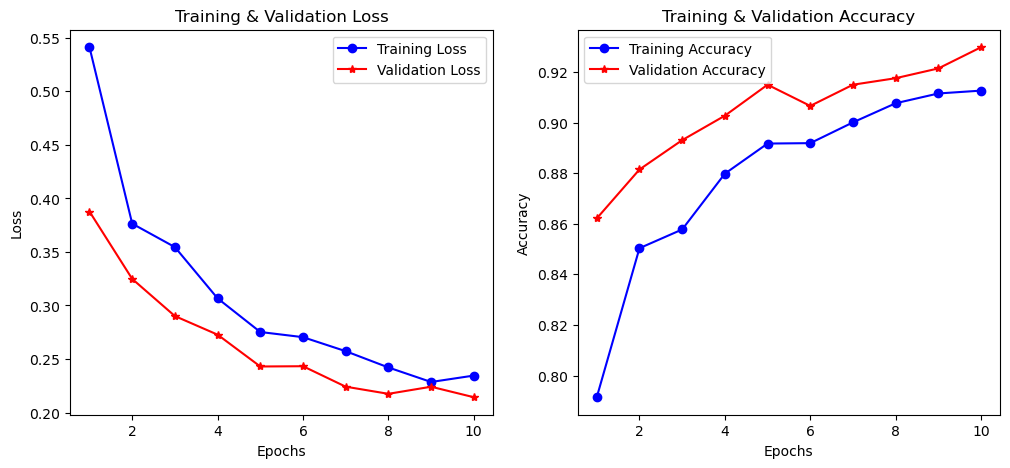

In [37]:
import matplotlib.pyplot as plt

# Function to plot training and validation accuracy & loss
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo-', label="Training Loss")
    plt.plot(epochs, history.history.get('val_loss', []), 'r*-', label="Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label="Training Accuracy")
    plt.plot(epochs, history.history.get('val_accuracy', []), 'r*-', label="Validation Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

# Call the function after training
plot_training_history(history)


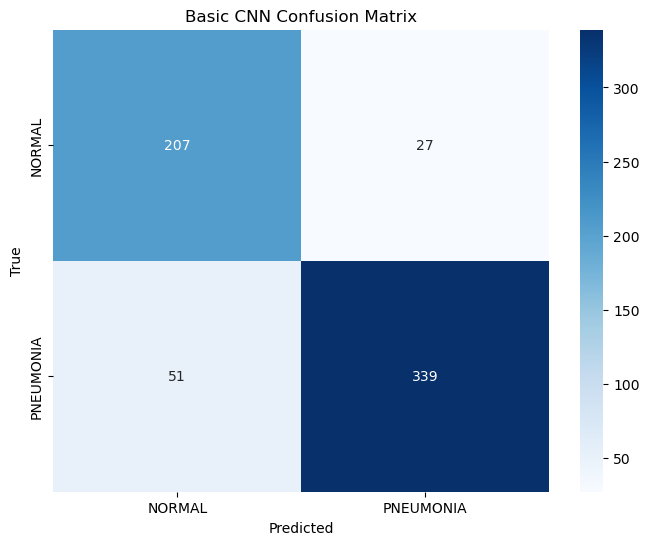

In [39]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.title(f"{name} Confusion Matrix")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [41]:
model.save("basic_cnn_model.h5")

In [1]:
def predict_image_class(model, img_path, class_labels):
    """Predict the class of a single image."""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    print(f"Predicted Class: {class_labels[predicted_class]} (Confidence: {predictions[0][predicted_class]:.2f})")
    return class_labels[predicted_class]


In [ ]:
from tensorflow.keras.preprocessing import image
example_img_path = r"C:\Users\ROSHAN JERUSH\Desktop\chest_xray\test\PNEUMONIA\person1_virus_7.jpeg" # Replace with an actual image path
class_labels = list(test_generator.class_indices.keys())
predicted_class = predict_image_class(basic_cnn_model, example_img_path, class_labels)

In [17]:
for layer in base_xception.layers:
    layer.trainable = False

x = base_xception.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
xception_output = Dense(2, activation='softmax')(x)

xception_model = Model(inputs=base_xception.input, outputs=xception_output)
xception_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model2 = {
    'Xception': xception_model
}

# Define callbacks correctly
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                      patience=3, min_lr=1e-6, verbose=1),  
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

for name, model in model2.items():
    print(f"Training {name}...")
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=10,
        callbacks=callbacks
    )

Training Xception...
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7222 - loss: 0.5613
Epoch 1: val_loss improved from inf to 0.26448, saving model to best_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 1233s 6s/step - accuracy: 0.7225 - loss: 0.5607 - val_accuracy: 0.9001 - val_loss: 0.2645 - learning_rate: 1.0000e-04
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8678 - loss: 0.3168
Epoch 2: val_loss improved from 0.26448 to 0.22210, saving model to best_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 1381s 7s/step - accuracy: 0.8678 - loss: 0.3168 - val_accuracy: 0.9149 - val_loss: 0.2221 - learning_rate: 1.0000e-04
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8787 - loss: 0.2956
Epoch 3: val_loss improved from 0.22210 to 0.21637, saving model to best_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 1721s 9s/step - accuracy: 0.8787 - loss: 0.2955 - val_accuracy: 0.9098 - val_loss: 0.2164 - learning_rate: 1.0000e-04
Epoch 4/10
195/195 ━━━━━━━━━━━━━

In [21]:
print(f"Evaluating {name}...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"{name} Test Accuracy: {test_accuracy:.2f}")


Evaluating Xception...
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.8941 - loss: 0.2289
Xception Test Accuracy: 0.82


In [23]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
print(f"{name} Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step
Xception Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.70      0.92      0.80       234
   PNEUMONIA       0.94      0.76      0.84       390

    accuracy                           0.82       624
   macro avg       0.82      0.84      0.82       624
weighted avg       0.85      0.82      0.83       624



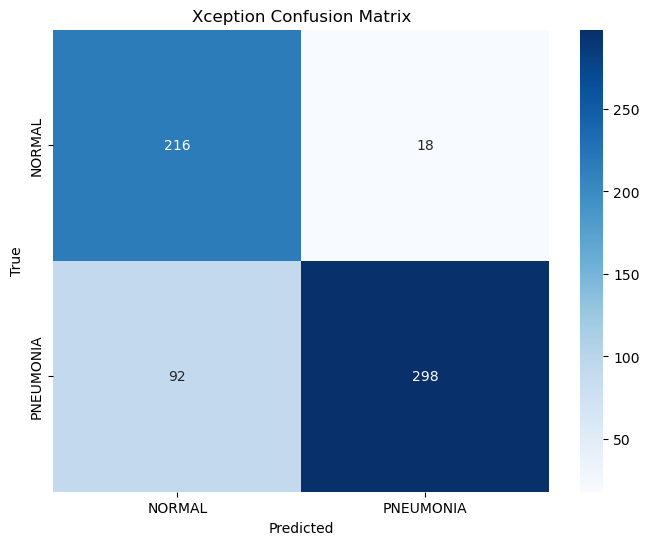

In [27]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.title(f"{name} Confusion Matrix")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [29]:
model.save("base_xception.h5")

In [25]:
def predict_image_class(model2, img_path, class_labels):
    """Predict the class of a single image."""
    from tensorflow.keras.preprocessing import image
    import numpy as np

    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  

    predictions = model2.predict(img_array)
    predicted_class = int(np.argmax(predictions, axis=1))  # Convert to int

    print(f"Predicted Class: {class_labels[predicted_class]} (Confidence: {predictions[0][predicted_class]:.2f})")
    return class_labels[predicted_class]


In [7]:
#vgg19
from tensorflow.keras.applications import VGG19
base_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_vgg19.layers:
    layer.trainable = False

x = base_vgg19.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
vgg19_output = Dense(2, activation='softmax')(x)

vgg19_model = Model(inputs=base_vgg19.input, outputs=vgg19_output)
vgg19_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Fine-tune VGG19 model
vgg19_model.trainable = True
for layer in vgg19_model.layers[:-5]:
    layer.trainable = False
vgg19_model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Reduced learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
model4 = {
    'VGG19': vgg19_model
}

callbacks = [
    
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

for name, model in model4.items():
    print(f"Training {name}...")
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=10,
        callbacks=callbacks
    )

Training VGG19...


C:\Users\ROSHAN JERUSH\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.8176 - loss: 0.4034 
Epoch 1: val_loss improved from inf to 0.21885, saving model to best_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 3931s 20s/step - accuracy: 0.8179 - loss: 0.4030 - val_accuracy: 0.9188 - val_loss: 0.2189 - learning_rate: 1.0000e-04
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9054 - loss: 0.2522 
Epoch 2: val_loss improved from 0.21885 to 0.18794, saving model to best_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 4305s 22s/step - accuracy: 0.9054 - loss: 0.2521 - val_accuracy: 0.9246 - val_loss: 0.1879 - learning_rate: 1.0000e-04
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9195 - loss: 0.2067 
Epoch 3: val_loss improved from 0.18794 to 0.17227, saving model to best_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 4114s 21s/step - accuracy: 0.9195 - loss: 0.2067 - val_accuracy: 0.9317 - val_loss: 0.1723 - learning_rate: 1.0000e-04
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [13]:
print(f"Evaluating {name}...")
test_loss, test_accuracy = model4['VGG19'].evaluate(test_generator, verbose=1)
print(f"{name} Test Accuracy: {test_accuracy:.2f}")


Evaluating VGG19...
20/20 ━━━━━━━━━━━━━━━━━━━━ 301s 15s/step - accuracy: 0.9489 - loss: 0.1554
VGG19 Test Accuracy: 0.92


In [15]:
y_true = test_generator.classes
y_pred = np.argmax(model4['VGG19'].predict(test_generator), axis=1)
print(f"{name} Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

20/20 ━━━━━━━━━━━━━━━━━━━━ 327s 16s/step
VGG19 Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.84      0.97      0.90       234
   PNEUMONIA       0.98      0.89      0.93       390

    accuracy                           0.92       624
   macro avg       0.91      0.93      0.92       624
weighted avg       0.93      0.92      0.92       624



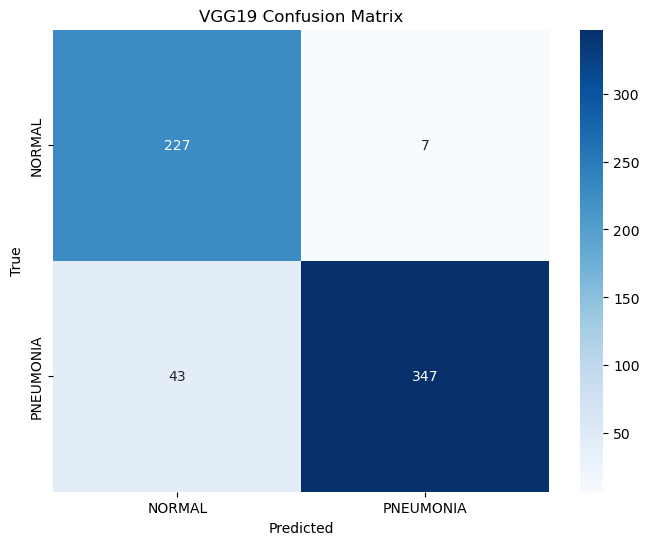

In [19]:
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.title(f"{name} Confusion Matrix")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
model4['VGG19'].save("base_vgg19.h5")

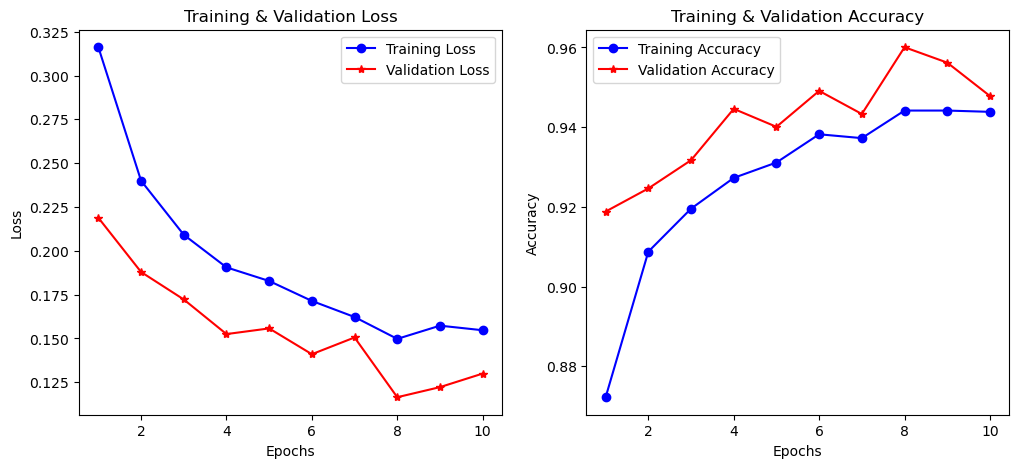

In [35]:
# Function to plot training and validation accuracy & loss
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo-', label="Training Loss")
    plt.plot(epochs, history.history.get('val_loss', []), 'r*-', label="Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label="Training Accuracy")
    plt.plot(epochs, history.history.get('val_accuracy', []), 'r*-', label="Validation Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

# Call the function after training
plot_training_history(history)

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# 🟢 Load Pre-trained ResNet50 (without top layers)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 🟢 Freeze initial layers (Keep only last few layers trainable)
for layer in base_model.layers[:140]:  
    layer.trainable = False  # Freeze lower layers

for layer in base_model.layers[140:]:  
    layer.trainable = True  # Fine-tune upper layers

# 🟢 Add Custom Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)  # Change based on your number of classes

# 🟢 Create Fine-Tuned Model
fine_tuned_resnet = Model(inputs=base_model.input, outputs=predictions)

# 🟢 ✅ FIXED: Compile the Correct Model
fine_tuned_resnet.compile(
    optimizer=Adam(learning_rate=0.00001),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 🟢 Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(filepath='best_fine_tuned_resnet.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# 🟢 Train Model
history = fine_tuned_resnet.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=callbacks
)

# 🟢 Save Model
fine_tuned_resnet.save("final_fine_tuned_resnet.keras")


C:\Users\ROSHAN JERUSH\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7187 - loss: 1.8985

C:\Users\ROSHAN JERUSH\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.85355, saving model to best_fine_tuned_resnet.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 1726s 9s/step - accuracy: 0.7189 - loss: 1.8980 - val_accuracy: 0.5052 - val_loss: 1.8536 - learning_rate: 1.0000e-05
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8293 - loss: 1.6177
Epoch 2: val_loss improved from 1.85355 to 1.59274, saving model to best_fine_tuned_resnet.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 2026s 10s/step - accuracy: 0.8293 - loss: 1.6176 - val_accuracy: 0.7674 - val_loss: 1.5927 - learning_rate: 1.0000e-05
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8537 - loss: 1.5721
Epoch 3: val_loss did not improve from 1.59274
195/195 ━━━━━━━━━━━━━━━━━━━━ 2028s 10s/step - accuracy: 0.8537 - loss: 1.5721 - val_accuracy: 0.7075 - val_loss: 1.7914 - learning_rate: 1.0000e-05
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8485 - loss: 1.5530
Epoch 4: val_loss improved from 1.59274 to 1.44701, saving model

In [9]:
    # 🟢 Evaluate Model on Test Data
test_loss, test_accuracy = fine_tuned_resnet.evaluate(test_generator)

print(f"🟢 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"🟢 Test Loss: {test_loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9032 - loss: 1.3274
🟢 Test Accuracy: 84.94%
🟢 Test Loss: 1.4342


In [11]:
from sklearn.metrics import classification_report
import numpy as np

# 🟢 Get True Labels and Predictions
y_true = test_generator.classes  # True labels
y_pred_probs = fine_tuned_resnet.predict(test_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# 🟢 Get Class Labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# 🟢 Generate Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("🟢 Classification Report:\n", report)


20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step
🟢 Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.74      0.93      0.82       234
   PNEUMONIA       0.95      0.80      0.87       390

    accuracy                           0.85       624
   macro avg       0.84      0.87      0.85       624
weighted avg       0.87      0.85      0.85       624



20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step


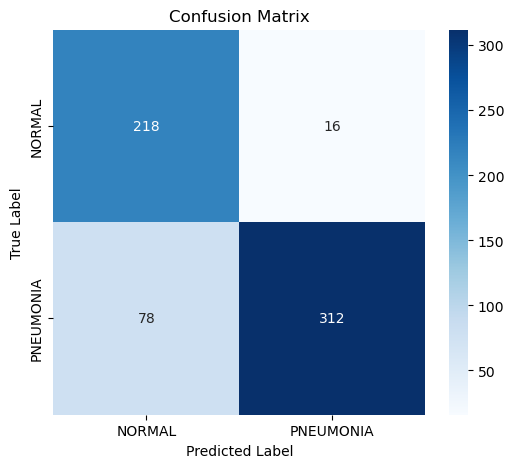

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 🟢 Get True Labels and Predictions
y_true = test_generator.classes  # True labels
y_pred_probs = fine_tuned_resnet.predict(test_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# 🟢 Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# 🟢 Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
